In [2]:
import numpy as np
import tensorflow as tf

In [19]:
class EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self,feat_num,field_num,emb_dim,*args,**kwargs):
        super(EmbeddingLayer,self).__init__(*args,**kwargs)
        self.feat_num=feat_num
        self.field_num=field_num
        self.emb_dim=emb_dim
        self.emb_layer=tf.keras.layers.Embedding(input_dim=feat_num,output_dim=emb_dim)

    def call(self, inputs, **kwargs):

        """

        :param inputs: a batch of data shape: [batch_size, 2, field_num]，在deep fm数据结构的基础上做了点改进，将feat_index和feat_value拼了起来，为的是最后容易画图
            分为两部分，你可以把他看做一个手动构造的稀疏矩阵，每个样本的输入形状都是[2, field_num]
            例如，如果inputs的数据为[[[1,5,9],[1,1,2.3]], [[2,7,8],[1,1,0.98]]]；
            假设第一个样本的特征向量是x，那么x[1]=1, x[5]=1, x[9]=2.3，其余位置取值均为0
            这样构造的好处和deep fm中描述的相同。
        :param kwargs:
        :return:
        """

        feat_indices_batch=inputs[:,0,:] # [batch_size, field_num]
        feat_value_batch=inputs[:,1,:] # [batch_size, field_num]
        assert inputs.shape[1:]==[2, self.field_num]

        emb_vectors=self.emb_layer(feat_indices_batch) # [batch_size, field_num, emb_dim]
        feat_value_batch = tf.expand_dims(feat_value_batch,axis=-1) # [batch_size, field_num, 1]

        # broadcast性质 feat_value_batch会被看做[batch_size, field_num, emb_dim]
        emb_vectors = tf.multiply(emb_vectors,feat_value_batch) # [batch_size, field_num, emb_dim]
        return emb_vectors

feat_indices_arr=[np.random.choice(range(10),size=[1,5],replace=False) for _ in range(9)]
feat_indices_arr=np.concatenate(feat_indices_arr,axis=0).astype(np.float32)
print("feat_indices_arr")
print(feat_indices_arr.shape) #[10,3]

feat_vals_arr=np.concatenate((np.ones(shape=[9,3]),
                              np.random.random(size=[9,2])),axis=1).astype(np.float32)
print("\nfeat_vals_arr")
print(feat_vals_arr.shape) # [10,3]

input_arr=np.stack((feat_indices_arr,feat_vals_arr),axis=1)
input_ds=tf.data.Dataset.from_tensor_slices(input_arr)
batched_ds=input_ds.batch(6)
iterator=iter(batched_ds)
input_batch=next(iterator)
print("\ninput_batch")
print(input_batch.shape)


print("\nemb vectors")
emb_layer=EmbeddingLayer(feat_num=10,field_num=5,emb_dim=4)
emb_outputs=emb_layer(input_batch)
print(emb_outputs.shape)

feat_indices_arr
(9, 5)

feat_vals_arr
(9, 5)

input_batch
(6, 2, 5)

emb vectors
(6, 5, 4)


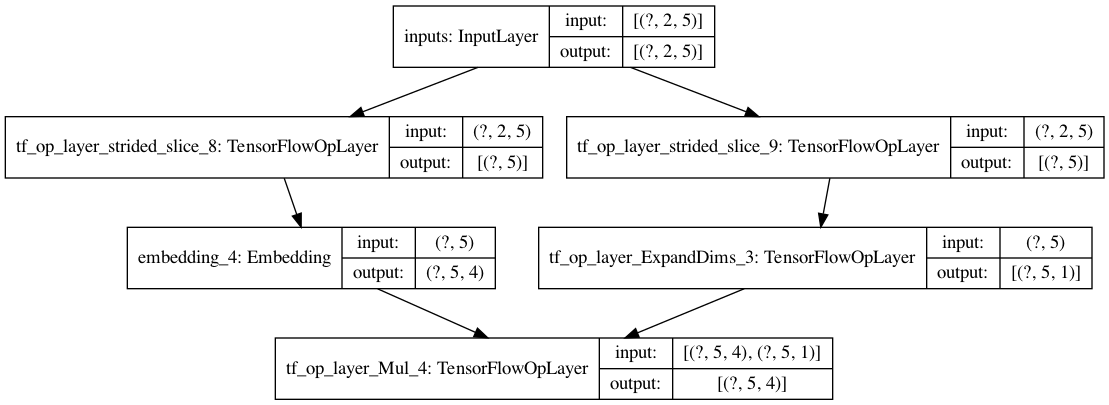

In [20]:

inputs=tf.keras.Input(shape=(2,5), dtype=tf.float32, name='inputs') # 里面的3指的是一个样本的维度
outputs=emb_layer.call(inputs)
model_for_plot=tf.keras.Model(inputs=inputs,outputs=outputs)
model_for_plot.compile()
tf.keras.utils.plot_model(model_for_plot,to_file="model.png", show_shapes=True,expand_nested=True)

In [21]:
from itertools import combinations

class PairWiseInteractionLayer(tf.keras.layers.Layer):
    def __init__(self,*args,**kwargs):
        super(PairWiseInteractionLayer,self).__init__(*args,**kwargs)

    def call(self, inputs, **kwargs):
        """

        :param inputs: shape [batch_size, field_num, emb_dim]
        :param kwargs:
        :return:
        """
        field_num=inputs.shape[1]
        left_indices=list()
        right_indices=list()
        for left_index,right_index in combinations(range(field_num),r=2):
            left_indices.append(left_index)
            right_indices.append(right_index)

        # 如果field_num是3，那么left_inputs就等于inputs[:,[0,0,1],:]，right_inputs就等于inputs[:,[1,2,2],:]
        left_inputs=tf.gather(params=inputs,indices=left_indices,axis=1) # [batch_size, pair_num=field_num*(field_num-1)/2, emb_dim]
        right_inputs=tf.gather(params=inputs,indices=right_indices,axis=1) # [batch_size, pair_num=field_num*(field_num-1)/2, emb_dim]
        y_pi=tf.multiply(left_inputs,right_inputs) # [batch_size, pair_num=field_num*(field_num-1)/2, emb_dim]
        return y_pi

pi_layer=PairWiseInteractionLayer()
pi_outputs=pi_layer(emb_outputs)
print("pi_outputs.shape")
print(pi_outputs.shape)

pi_outputs.shape
(6, 10, 4)


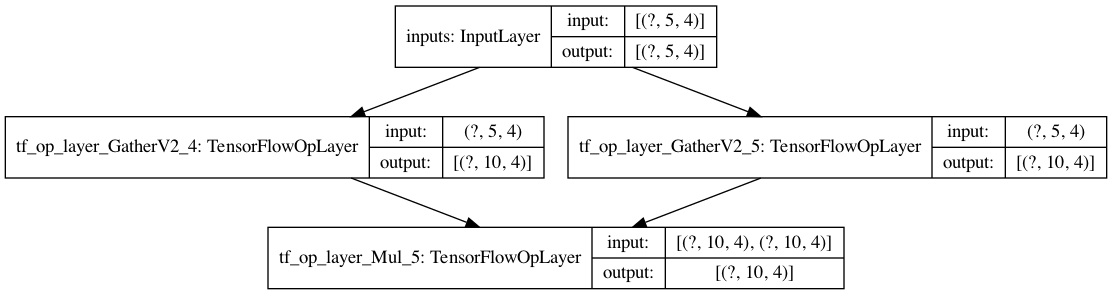

In [22]:
inputs=tf.keras.Input(shape=(5,4), dtype=tf.float32, name='inputs') # 里面的3指的是一个样本的维度
outputs=pi_layer.call(inputs)
model_for_plot=tf.keras.Model(inputs=inputs,outputs=outputs)
model_for_plot.compile()
tf.keras.utils.plot_model(model_for_plot,to_file="model.png", show_shapes=True,expand_nested=True)

In [23]:
class AttentionBasedPooling(tf.keras.layers.Layer):
    def __init__(self,attention_layer_units,*args,**kwargs):
        """

        :param attention_layer_units: 对应paper中的t
        :param args:
        :param kwargs:
        """
        super(AttentionBasedPooling,self).__init__(*args,**kwargs)
        self.d1=tf.keras.layers.Dense(units=attention_layer_units, activation=tf.nn.relu)
        self.d2=tf.keras.layers.Dense(units=1, activation=None,use_bias=False)

    def call(self, inputs, **kwargs):
        """

        :param inputs: [batch_size, pair_num=field_num*(field_num-1)/2, emb_dim]
        :param kwargs:
        :return:
        """
        attention_score=self.d1(inputs) # [batch_size, pair_num=field_num*(field_num-1)/2, attention_layer_units]
        attention_score=self.d2(attention_score) # [batch_size, pair_num=field_num*(field_num-1)/2, 1]

        sum_pooling=tf.multiply(inputs,attention_score) # [batch_size, pair_num=field_num*(field_num-1)/2, emb_dim]
        sum_pooling=tf.reduce_sum(sum_pooling,axis=1)  # [batch_size, emb_dim]
        return sum_pooling

attention_pooling_layer=AttentionBasedPooling(attention_layer_units=2)
attention_pooling=attention_pooling_layer(pi_outputs)
print("attention_pooling.shape")
print(attention_pooling.shape)

attention_pooling.shape
(6, 4)


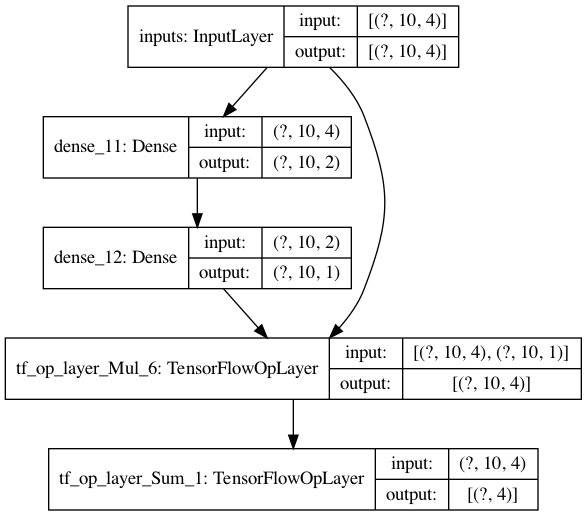

In [24]:
inputs=tf.keras.Input(shape=(10,4), dtype=tf.float32, name='inputs') # 里面的3指的是一个样本的维度
outputs=attention_pooling_layer.call(inputs)
model_for_plot=tf.keras.Model(inputs=inputs,outputs=outputs)
model_for_plot.compile()
tf.keras.utils.plot_model(model_for_plot,to_file="model.png", show_shapes=True,expand_nested=True)

In [28]:
class AFM(tf.keras.Model):
    def __init__(self,feat_num,field_num,emb_dim,attention_layer_units,scoring_units=2,*args,**kwargs):
        super(AFM,self).__init__(*args,**kwargs)
        self.feat_num=feat_num
        self.field_num=field_num
        self.emb_dim=emb_dim
        self.scoring_units=scoring_units
        self.emb_layer=EmbeddingLayer(feat_num=feat_num,field_num=field_num,emb_dim=emb_dim)
        self.pi_layer=PairWiseInteractionLayer()
        self.attention_pooling_layer=AttentionBasedPooling(attention_layer_units=attention_layer_units)
        self.afm_scoring_layer=tf.keras.layers.Dense(units=scoring_units,activation=None,use_bias=True) # 一阶的那个w0我放在这个layer的bias里了，也就是use_bias

        # self.first_term_scoring_layer_weights=tf.Variable(tf.random.truncated_normal(shape=[feat_num,scoring_units]))
        # 使用一个embedding layer来储存一阶项权重，没用tf.nn.embedding_lookup，因为这个op没办法使用keras作图
        self.first_term_scoring_layer_weights_table=tf.keras.layers.Embedding(input_dim=feat_num,output_dim=scoring_units)

    def call(self, inputs, training=None, mask=None):
        """

        :param inputs: a batch of data shape: [batch_size, 2, field_num]，在deep fm数据结构的基础上做了点改进，将feat_index和feat_value拼了起来，为的是最后容易画图
            分为两部分，你可以把他看做一个手动构造的稀疏矩阵，每个样本的输入形状都是[2, field_num]
            例如，如果inputs的数据为[[[1,5,9],[1,1,2.3]], [[2,7,8],[1,1,0.98]]]；
            假设第一个样本的特征向量是x，那么x[1]=1, x[5]=1, x[9]=2.3，其余位置取值均为0
            这样构造的好处和deep fm中描述的相同。
        :param training:
        :param mask:
        :return:
        """
        feat_indices_batch=tf.cast(inputs[:,0,:],dtype=tf.int32) # [batch_size, field_num]
        feat_value_batch=inputs[:,1,:] # [batch_size, field_num]
        assert inputs.shape[1:]==[2, self.field_num]

        emb_outputs=self.emb_layer(inputs) # [batch_size, field_num, emb_dim]
        pi_outputs=self.pi_layer(emb_outputs) # [batch_size, pair_num=field_num*(field_num-1)/2, emb_dim]
        attention_pooling=self.attention_pooling_layer(pi_outputs) # [batch_size, emb_dim]
        afm_component_outputs=self.afm_scoring_layer(attention_pooling) # [batch_size, scoring_units]

        # first_term_weights=tf.nn.embedding_lookup(self.first_term_scoring_layer_weights,ids=feat_indices_batch) # [batch_size, field_num, scoring_units]
        first_term_weights=self.first_term_scoring_layer_weights_table(feat_indices_batch) # [batch_size, field_num, scoring_units]
        first_term=tf.matmul(first_term_weights,tf.expand_dims(feat_value_batch,axis=2),transpose_a=True) # [batch_size, scoring_units]
        first_term=tf.reshape(first_term,shape=[-1,self.scoring_units])
        return first_term+afm_component_outputs

feat_indices_arr=[np.random.choice(range(10),size=[1,5],replace=False) for _ in range(9)]
feat_indices_arr=np.concatenate(feat_indices_arr,axis=0).astype(np.float32)
print("feat_indices_arr")
print(feat_indices_arr.shape) #[10,3]

feat_vals_arr=np.concatenate((np.ones(shape=[9,3]),
                              np.random.random(size=[9,2])),axis=1).astype(np.float32)
print("\nfeat_vals_arr")
print(feat_vals_arr.shape) # [10,3]

input_arr=np.stack((feat_indices_arr,feat_vals_arr),axis=1)
input_ds=tf.data.Dataset.from_tensor_slices(input_arr)
batched_ds=input_ds.batch(6)
iterator=iter(batched_ds)
input_batch=next(iterator)
print("\ninput_batch")
print(input_batch.shape)


print("\namf_outputs.shape")
afm=AFM(feat_num=10,field_num=5,emb_dim=4,attention_layer_units=2)
amf_outputs=afm(input_batch)
print(amf_outputs.shape)

feat_indices_arr
(9, 5)

feat_vals_arr
(9, 5)

input_batch
(6, 2, 5)

amf_outputs.shape
(6, 2)


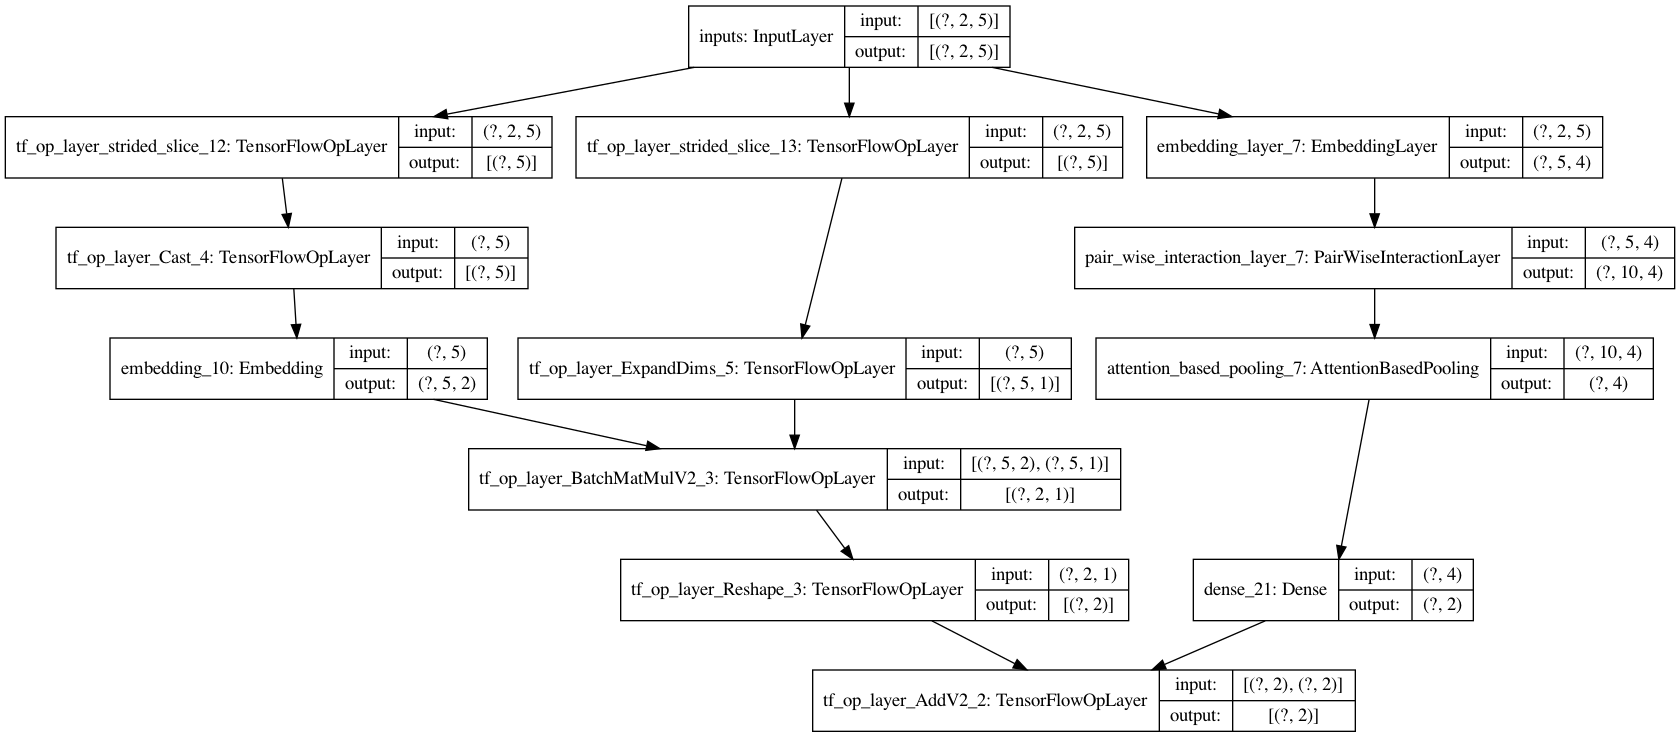

In [29]:
inputs=tf.keras.Input(shape=(2,5), dtype=tf.float32, name='inputs') # 里面的3指的是一个样本的维度
outputs=afm.call(inputs)
model_for_plot=tf.keras.Model(inputs=inputs,outputs=outputs)
model_for_plot.compile()
tf.keras.utils.plot_model(model_for_plot,to_file="model.png", show_shapes=True,expand_nested=True)
